<a href="https://colab.research.google.com/github/Kabongosalomon/Word-Embedding-Investigation/blob/Dev-Update/One_hot_and_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/Kabongosalomon/Data-Science-With-Jeff-Sander/master/aims-za-logo.jpg" width="100" alt="cognitiveclass.ai logo" />





In [1]:
# Import packages
import tensorflow as tf


from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import losses
from keras import metrics
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

import os

import numpy as np

import string

!pip install ipdb -q
import ipdb # deb


from gensim.models.keyedvectors import KeyedVectors

Using TensorFlow backend.
paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


# One-hot encoding of words and characters

One-hot encoding is the most common, most basic way to turn a token into a vector.

It consists of associating a unique integer index with every word
and then turning this integer index i into a binary vector of size N (the size of the
vocabulary); the vector is all zeros except for the i th entry, which is 1.

## Manually

### One-hot Word-level

In [0]:
# Initial data: one entry per sample (in 
# this example, a sample is a sentence, 
# but it could be an entire document)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Builds an index of all tokens in the data
token_index = {}

for sample in samples:
    for word in sample.split(): # Tokenizes the samples via the split
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # Assigns a unique index to each unique word

# Vectorizes the samples. You’ll only
# consider the first max_length
# words in each sample.            
max_length = 10  # window

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word) #; ipdb.set_trace()
        results[i, j, index] = 1.

In [0]:
token_index

{'The': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'the': 5,
 'mat.': 6,
 'dog': 7,
 'ate': 8,
 'my': 9,
 'homework.': 10}

In [0]:
results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

### Character-level

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

characters = string.printable

token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50

results = np.zeros((len(samples), 
                    max_length, 
                    max(token_index.keys()) + 1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)  #; ipdb.set_trace()
        results[i, j, index] = 1.

In [0]:
results

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

**Keras has built-in utilities for doing one-hot encoding of text at the word level
or character level**, starting from raw text data. 

We should use these utilities, because they take care of a number of important features such as stripping special characters from strings and only taking into account the N most common words in your dataset (a common restriction, to avoid dealing with very large input vector spaces).

## Using Keras build in function

### Word level

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [0]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [0]:
one_hot_results

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]])

In [0]:
word_index

{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

In [0]:
# # Vectorizes the samples. You’ll only
# # consider the first max_length
# # words in each sample.            
# max_length = 10  # window

# results = np.zeros(shape=(len(samples),
#                           max_length,
#                           len(word_index) + 1))

# for i, sample in enumerate(samples):
#     for j, word in list(enumerate(sample.split()))[:max_length]:
#         index = word_index.get(word) #; ipdb.set_trace()
#         results[i, j, index] = 1.

In [0]:
# results

### Caracter level

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17 unique tokens.


In [0]:
sequences

[[2, 4, 3, 1, 9, 5, 2, 1, 10, 5, 2, 1, 6, 11, 1, 2, 4, 3, 1, 7, 5, 2, 8],
 [2,
  4,
  3,
  1,
  12,
  6,
  13,
  1,
  5,
  2,
  3,
  1,
  7,
  14,
  1,
  4,
  6,
  7,
  3,
  15,
  6,
  16,
  17,
  8]]

In [0]:
one_hot_results

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 1.]])

In [0]:
word_index

{' ': 1,
 't': 2,
 'e': 3,
 'h': 4,
 'a': 5,
 'o': 6,
 'm': 7,
 '.': 8,
 'c': 9,
 's': 10,
 'n': 11,
 'd': 12,
 'g': 13,
 'y': 14,
 'w': 15,
 'r': 16,
 'k': 17}

##  hashing trick

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
#         Hashes the word into a 
#         random integer index 
#         between 0 and 1,000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense
word vectors, also called word embeddings. Whereas the vectors obtained through one-hot
encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same
dimensionality as the number of words in the vocabulary), word embeddings are low-
dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vec-
tors);

Unlike the  word vectors  obtained  via one-hot  encoding,  **word embeddings  are  learned  from  data**. It’s common  to  see  word  embeddings  that are
256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large
vocabularies. 

On the other hand, one-hot encoding words generally leads to vectors
that are 20,000-dimensional or greater (capturing a vocabulary of 20,000 tokens, in
this case). 

So, word embeddings *pack more information into far fewer dimensions*.

There are two ways to obtain word embeddings:
- Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
-  Load into your model word embeddings that were pretrained using a different machinelearning task than the one you’re trying to solve.

Word embeddings are meant to *map human language into a geometric space*. For instance, in a reasonable embedding space, you would expect synonyms to be embedded into similar word vectors; and in general, you would expect the geometric distance (such as L2 distance) between any two word vectors to relate to the semantic distance between the associated words (words meaning different things are embedded at points far away from
each other, whereas related words are closer). 

In addition to distance, you may want
specific directions in the embedding space to be meaningful.

## Task specific Embedding for DataSet IMDB (keras.datasets)

In [0]:
# Number of words to 
# consider as features
max_features = 10000

# Cuts off the text after this 
# number of words (among 
# the max_features most 
# common words)
# maxlen = 20
maxlen = 500

# Loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# (x_train, y_train), (x_test, y_test) = imdb.load_data()

In [0]:
# Turns the lists of integers into
# a 2D integer tensor of shape
# (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
x_train.shape

(25000, 500)

In [5]:
x_test.shape

(25000, 500)

In [4]:
model = Sequential()
# Specifies the maximum input length to the 
# Embedding layer so you can later flatten the 
# embedded inputs. After the Embedding layer, 
# the activations have shape (samples, maxlen, 8).
model.add(Embedding(10000, 8, input_length=x_train.shape[1]))
# Flattens the 3D tensor of 
# embeddings into a 2D 
# tensor of shape (samples, maxlen * 8)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4001      
Total params: 84,001
Trainable params: 84,001
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2) # Split validation of 20% automatically)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 218us/step - loss: 0.5857 - acc: 0.7083 - val_loss: 0.3974 - val_acc: 0.8430
Epoch 2/10
20000/20000 [==============================] - 2s 97us/step - loss: 0.3015 - acc: 0.8848 - val_loss: 0.2895 - val_acc: 0.8824
Epoch 3/10
20000/20000 [==============================] - 2s 97us/step - loss: 0.2219 - acc: 0.9148 - val_loss: 0.2768 - val_acc: 0.8876
Epoch 4/10
20000/20000 [==============================] - 2s 97us/step - loss: 0.1826 - acc: 0.9311 - val_loss: 0.2684 - val_acc: 0.8934
Epoch 5/10
20000/20000 [==============================] - 2s 85us/step - loss: 0.1554 - acc: 0.9431 - val_loss: 0.2723 - val_acc: 0.8912
Epoch 6/10
20000/20000 [==============================] - 2s 85us/step - loss: 0.1344 - acc: 0.9503 - val_loss: 0.2801 - val_acc: 0.8904
Epoch 7/10
20000/20000 [==============================] - 2s 85us/step - loss: 0

In [8]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 1s 36us/step
Metric  loss : 0.34958
Metric  acc : 0.873


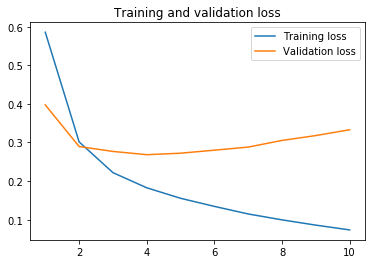

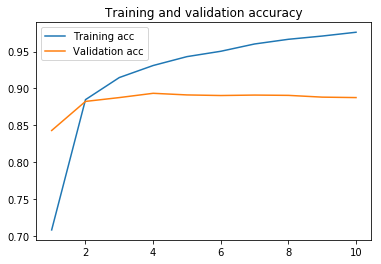

In [9]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

We can see that our model start well but quickly overfit.

We get to a validation accuracy of ~87%, on enseen example, which is pretty good considering that we’re only looking at the first 500 words in every review. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that **treats  each  word  in  the  input  sequence  separately,  without  considering  inter-word relationships and sentence structure** (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). 

Let look at how to capture those **inter-word relationships* *

There exist 2 main approach :

1. *adding a recurrent layers or*
2. *adding a 1D convolutional layers on top of the embedded  sequences  to  learn  features  that  take  into  account  each  sequence  as  a  whole*.

**We will look at it at the end of this notebook. **

## USING PRETRAINED WORD EMBEDDINGS

### Load the Internet Movie Database (IMdb) from downloaded file

First, head to http://mng.bz/0tIo and download the raw IMDB dataset. Uncompress it.

Now, let’s collect the individual training reviews into a list of strings, one string per review. We’ll also collect the review labels (positive/negative) into a labels list.

#### Preprocess

In [5]:
# Number of words to 
# consider as features
max_features = 10000      # Words are ranked

# Cuts off texts after this many words (among 
# the max_features most common words)
max_len = 500

print('Loading data...')
(x_train_, y_train_), (x_test_, y_test_) = tf.keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train_), 'train sequences')
print(len(x_test_), 'test sequences')

print('Pad sequences (samples x time)')
x_train_ = tf.keras.preprocessing.sequence.pad_sequences(
    x_train_, maxlen=max_len)
x_test_ = tf.keras.preprocessing.sequence.pad_sequences(
    x_test_, maxlen=max_len)
print('x_train shape:', x_train_.shape)
print('x_test shape:', x_test_.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [12]:
link = "https://drive.google.com/file/d/1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW
    100% |████████████████████████████████| 993kB 27.1MB/s 


In [13]:
!ls

aclImdb.zip  adc.json  sample_data


In [0]:
!unzip -qq aclImdb.zip

In [15]:
!ls

aclImdb  aclImdb.zip  adc.json	__MACOSX  sample_data


In [0]:
# imdb_dir = './data/aclImdb'
imdb_dir = './aclImdb'

# Reading in the training folder
train_dir = os.path.join(imdb_dir, 'train')
labels_tr = []
texts_tr = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts_tr.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_tr.append(0)
            else:
                labels_tr.append(1)

# Reading in the testing folder
train_dir = os.path.join(imdb_dir, 'test')
labels_tst = []
texts_tst = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts_tst.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_tst.append(0)
            else:
                labels_tst.append(1)

 let's also verify the number of samples that are present in each class.

In [7]:
uniq_class_arr, counts = np.unique(labels_tr, return_counts=True)

print ('Unique classes :', uniq_class_arr)
print ('Number of unique classes : ', len(uniq_class_arr))

for _class in uniq_class_arr:
    print ('Counts for class ', uniq_class_arr[_class], ' : ', counts[_class])

Unique classes : [0 1]
Number of unique classes :  2
Counts for class  0  :  12500
Counts for class  1  :  12500


Now, let;s take a few random samples and check if the labels are expected!

In [6]:
size_of_samp = 10
rand_samples_to_check = np.random.randint(len(texts_tr), size=size_of_samp)

for samp_num in rand_samples_to_check:
    print ('============================================================')
    print (texts_tr[samp_num], '||', labels_tr[samp_num])
    print ('============================================================')

Unless somebody enlightens me, I really have no idea what this movie is about. It looks like a picture with a message but it´s far from it. This movie tells pointless story of a New York press agent and about his problems. And, that´s basically all. When that agent is played by Pacino, one must think that it must be something important. But it takes no hard thinking to figure out how meaningless and dull this movie is. To one of the best actors in the world, Al Pacino, this is the second movie of the year (the other is "Simone") that deserves the title "the most boring and the most pointless motion picture of the year". So, what´s going on, Al? || 0
After reading the previous comments, I'm just glad that I wasn't the only person left confused, especially by the last 20 minutes. John Carradine is shown twice walking down into a grave and pulling the lid shut after him. I anxiously awaited some kind of explanation for this odd behavior...naturally I assumed he had something to do with th

### TOKENIZING THE DATA

Let’s vectorize the text and prepare a training and validation split. Pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we’ll add the following twist: restricting the training data to the first $200 samples$. So you’ll learn to classify movie reviews after looking at just 200 examples.

In [0]:
# Cuts off reviews after 100 words
# maxlen = 100
maxlen = 500

# # Trains on 200 samples
training_samples = 200
# # training_samples = 15000

# # Validates on 10,000 samples
# validation_samples = 10000

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

# Training
tokenizer_tr = Tokenizer(num_words=max_words)
# tokenizer = Tokenizer()
tokenizer_tr.fit_on_texts(texts_tr)
sequences_tr = tokenizer_tr.texts_to_sequences(texts_tr)

# Testing 
tokenizer_tst = Tokenizer(num_words=max_words)
tokenizer_tst.fit_on_texts(texts_tst)
sequences_tst = tokenizer_tst.texts_to_sequences(texts_tst)

In [0]:
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

# data = pad_sequences(sequences, maxlen=maxlen)
# labels = np.asarray(labels)
# print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

# # Splits the data into a training set and a 
# # validation set, but first shuffles the data, 
# # because you’re starting with data in which 
# # samples are ordered (all negative first, then 
# # all positive) 
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]

# x_train = data[:training_samples]
# y_train = labels[:training_samples]
# x_val = data[training_samples: training_samples + validation_samples]
# y_val = labels[training_samples: training_samples + validation_samples]

In [9]:
word_index = tokenizer_tr.word_index # only based on the training 
print('Found %s unique tokens.' % len(word_index))

# Train 
data_tr = pad_sequences(sequences_tr, maxlen=maxlen)
labels_tr = np.asarray(labels_tr)
print('\nTraining Part\n ##############')
print('Shape of data tensor:', data_tr.shape)
print('Shape of label tensor:', labels_tr.shape)



# Testing 
data_tst = pad_sequences(sequences_tst, maxlen=maxlen)
labels_tst = np.asarray(labels_tst)
print('\nTesting Part\n ##############')
print('Shape of data tensor:', data_tst.shape)
print('Shape of label tensor:', labels_tst.shape)

Found 88582 unique tokens.

Training Part
 ##############
Shape of data tensor: (25000, 500)
Shape of label tensor: (25000,)

Testing Part
 ##############
Shape of data tensor: (25000, 500)
Shape of label tensor: (25000,)


One May run this cell several time to check how the accuracy is affected as we suffle the data

In [10]:
# Splits the data into a training set and a 
# validation set, but first shuffles the data, 
# because you’re starting with data in which 
# samples are ordered (all negative first, then 
# all positive) 
indices = np.arange(data_tr.shape[0])
np.random.shuffle(indices)
x_train = data_tr[indices]
x_train = x_train[:training_samples]

y_train = labels_tr[indices]
y_train = y_train[:training_samples]


# Splits the data into a training set and a 
# validation set, but first shuffles the data, 
# because you’re starting with data in which 
# samples are ordered (all negative first, then 
# all positive) 
indices = np.arange(data_tst.shape[0])
np.random.shuffle(indices)
x_test = data_tst[indices]
y_test = labels_tst[indices]

#Explore the data structure using basic python commands
print("Type of the Dataset:",type(x_train))
print("Shape of training data :",x_train.shape)
print("Shape of training labels :",y_train.shape)
print("Shape of testing data :",x_test.shape)
print("Shape of testing labels :",y_test.shape)

Type of the Dataset: <class 'numpy.ndarray'>
Shape of training data : (200, 500)
Shape of training labels : (200,)
Shape of testing data : (25000, 500)
Shape of testing labels : (25000,)


Now, let;s take a few random samples and check if the labels are expected!

###  GLOVE WORD EMBEDDINGS

Go  to  https://nlp.stanford.edu/projects/glove,  and  download  the  precomputed
embeddings from 2014 English Wikipedia.  It’s an 822 MB zip file called glove.6B.zip,
containing  300-dimensional  embedding  vectors  for  400,000  words  (or  nonword
tokens). Unzip it. 

In [43]:
link = "https://drive.google.com/file/d/1qlkC4-gpOhJVVvja8NEnnYPJFFzUu1CW/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1qlkC4-gpOhJVVvja8NEnnYPJFFzUu1CW


In [44]:
!ls

aclImdb  aclImdb.zip  adc.json	glove.840B.300d.zip  __MACOSX  sample_data


In [46]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [47]:
# PREPROCESSING THE EMBEDDINGS
# glove_dir = './data/glove.6B'
glove_dir = './'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.840B.300d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = ''.join(values[:-300]) # 300 as our file has 300d
    coefs = np.asarray(values[-300:], dtype='float32') #; ipdb.set_trace()
    embeddings_index[word] = coefs
f.close()

# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 2195892 word vectors.


Well, we have axactly $2,195,89$ words as expected, of dimension $100$

In [79]:
embeddings_index['hello'].shape

(300,)

Next, you’ll build an embedding matrix that you can load into an Embedding layer. It
must be a matrix of shape $(max\_words, embedding_dim=1000)$, where each entry i contains
the embedding_dim-dimensional vector for the word of index i in the reference word
index (built during tokenization). Note that index 0 isn’t supposed to stand for any
word or token—it’s a placeholder

In [0]:
embedding_dim = embeddings_index['hello'].shape[0]
# Cuts off reviews after 100 words
maxlen = 500

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        embedding_vector = embeddings_index.get(word)
        # cheking that th eword exist in the embedding dictionary
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

In [81]:
embedding_matrix[-1] # looking at the last element

array([-0.068528  ,  0.45958999,  0.018539  , -0.53644001,  0.35394001,
       -0.35152   ,  0.078778  ,  0.12740999,  0.52928001,  0.62096   ,
       -0.75994003, -0.31343001,  0.13381   , -0.03789   , -0.40671   ,
       -0.098737  ,  0.13415   ,  0.90764999,  0.34279999, -0.52192003,
       -0.23233999, -0.29030001,  0.37049001, -0.56544   , -0.0023271 ,
        0.13129   , -0.49311   ,  0.16054   ,  0.099735  , -0.13713001,
        0.32255   , -0.25729999,  0.11523   ,  0.099993  ,  0.078515  ,
        0.31130001, -0.21955   ,  0.15638   ,  0.27340001,  0.22973999,
       -0.1997    , -0.025547  , -0.26411   , -0.099569  , -0.34459999,
       -0.20026   ,  0.17815   ,  0.1339    ,  0.24776   ,  0.028355  ,
       -0.36414   , -0.13376001,  0.098335  , -0.86383998,  0.082803  ,
        0.25937   , -0.0073275 ,  0.36594   , -0.014414  , -0.18960001,
       -0.84470999, -0.14161   , -0.030128  , -0.27522999,  0.16633999,
        0.18104   , -0.41111001,  0.15974   , -0.24508999, -0.20

In [83]:
embedding_matrix.shape

(10000, 300)

In [49]:
print(f"Max_words = {max_words}, \nEmbedding_dim = {embedding_dim} and \nInput_length = {maxlen}")

Max_words = 10000, 
Embedding_dim = 300 and 
Input_length = 500


In [50]:
model = tf.keras.Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3000000   
_________________________________________________________________
flatten (Flatten)            (None, 150000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4800032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,800,065
Trainable params: 4,800,065
Non-trainable params: 3,000,000
_________________________________________________________________


In [53]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2)

# model.save_weights('pre_trained_word2vec_model.h5')

Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 0s 1ms/sample - loss: 2.5403 - acc: 0.4313 - val_loss: 0.8823 - val_acc: 0.6750
Epoch 2/10
160/160 [==============================] - 0s 211us/sample - loss: 0.5078 - acc: 0.8000 - val_loss: 0.7979 - val_acc: 0.6750
Epoch 3/10
160/160 [==============================] - 0s 209us/sample - loss: 0.1575 - acc: 0.9438 - val_loss: 0.7950 - val_acc: 0.6750
Epoch 4/10
160/160 [==============================] - 0s 219us/sample - loss: 0.0662 - acc: 1.0000 - val_loss: 0.7961 - val_acc: 0.6500
Epoch 5/10
160/160 [==============================] - 0s 218us/sample - loss: 0.0389 - acc: 1.0000 - val_loss: 0.8022 - val_acc: 0.6500
Epoch 6/10
160/160 [==============================] - 0s 259us/sample - loss: 0.0268 - acc: 1.0000 - val_loss: 0.8057 - val_acc: 0.6500
Epoch 7/10
160/160 [==============================] - 0s 216us/sample - loss: 0.0189 - acc: 1.0000 - val_loss: 0.8120 - val_acc: 0.6500
Epoch

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is
the word vector meant to be associated with index i. Simple enough. Load the GloVe
matrix you prepared into the Embedding layer, the first layer in the model.

In [55]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 1s 59us/sample - loss: 2.0270 - acc: 0.4964
Metric  loss : 2.02696
Metric  acc : 0.4964


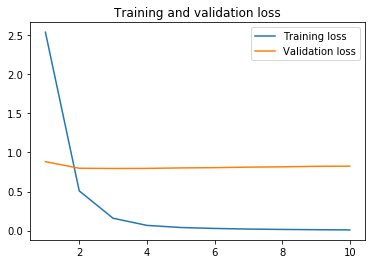

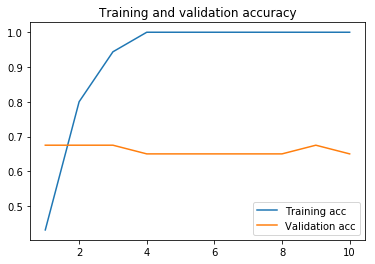

In [56]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#### 1D convnt

In [57]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1))

model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           67232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,074,465
Trainable params: 74,465
Non-trainable params: 3,000,000
_____________________________________________________________

In [58]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2)
#                     validation_data=(x_val, y_val))

# model.save_weights('pre_trained_word2vec_model.h5')

Train on 160 samples, validate on 40 samples
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
160/160 [==============================] - 3s 21ms/sample - loss: 7.4730 - acc: 0.5312 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 2/10
160/160 [==============================] - 0s 216us/sample - loss: 7.4730 - acc: 0.5312 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 3/10
160/160 [==============================] - 0s 217us/sample - loss: 7.4730 - acc: 0.5312 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 4/10
160/160 [==============================] - 0s 212us/sample - loss: 7.4730 - acc: 0.5312 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 5/10
160/160 [==============================] - 0s 207us/sample - loss: 7.4730 - acc: 0.5312 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 6/10
160/160 [==============================] - 0s 206us/sample - loss: 7.4730 - acc: 0.5312 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 7/10
160/160 [==============================] - 0s 199us

In [59]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 2s 71us/sample - loss: 7.9263 - acc: 0.5000
Metric  loss : 7.92631
Metric  acc : 0.49996


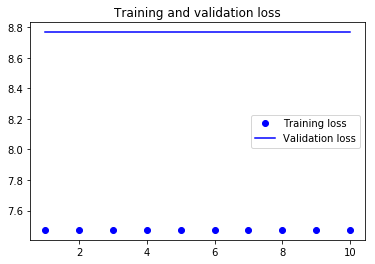

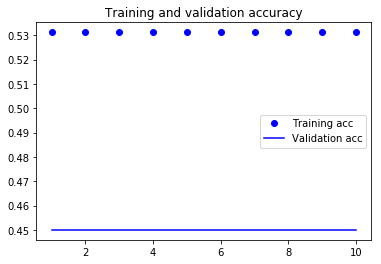

In [60]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### WORD2VEC EMBEDDINGS

Developed  by  Tomas  Mikolov  at  Google  in  2013.  Word2vec (https://code.google.com/archive/p/word2vec)
dimensions capture specific semantic properties

In [11]:
link = "https://drive.google.com/file/d/13NmrtF-HoGmdv_m3Ld4eGVTbIekOcNi_/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

13NmrtF-HoGmdv_m3Ld4eGVTbIekOcNi_


In [12]:
!ls

aclImdb      glove.840B.300d.txt		 __MACOSX
aclImdb.zip  glove.840B.300d.zip		 sample_data
adc.json     GoogleNews-vectors-negative300.bin


In [0]:
gensim_w2v = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [27]:
print('hello =', gensim_w2v['hello'])

hello = [-0.05419922  0.01708984 -0.00527954  0.33203125 -0.25       -0.01397705
 -0.15039062 -0.265625    0.01647949  0.3828125  -0.03295898 -0.09716797
 -0.16308594 -0.04443359  0.00946045  0.18457031  0.03637695  0.16601562
  0.36328125 -0.25585938  0.375       0.171875    0.21386719 -0.19921875
  0.13085938 -0.07275391 -0.02819824  0.11621094  0.15332031  0.09082031
  0.06787109 -0.0300293  -0.16894531 -0.20800781 -0.03710938 -0.22753906
  0.26367188  0.012146    0.18359375  0.31054688 -0.10791016 -0.19140625
  0.21582031  0.13183594 -0.03515625  0.18554688 -0.30859375  0.04785156
 -0.10986328  0.14355469 -0.43554688 -0.0378418   0.10839844  0.140625
 -0.10595703  0.26171875 -0.17089844  0.39453125  0.12597656 -0.27734375
 -0.28125     0.14746094 -0.20996094  0.02355957  0.18457031  0.00445557
 -0.27929688 -0.03637695 -0.29296875  0.19628906  0.20703125  0.2890625
 -0.20507812  0.06787109 -0.43164062 -0.10986328 -0.2578125  -0.02331543
  0.11328125  0.23144531 -0.04418945  0.108398

In [0]:
# gensim_model.save_word2vec_format('./data/GoogleNews-vectors-negative300.txt', binary=False)

In [14]:
type(gensim_w2v['hello'])

numpy.ndarray

In [0]:
gensim_w2v['hello'].shape

(300,)

In [0]:
gensim_w2v["0"].shape

(300,)

In [0]:
type(gensim_w2v['0'])

numpy.ndarray

In [46]:
# 3000000 words
len(gensim_w2v.vocab)

3000000

In [0]:
embedding_dim = gensim_w2v["0"].shape[0]

# Cuts off reviews after 500 words
maxlen = 500

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        if word not in gensim_w2v.vocab:
            pass; # we need to find a clever way to handle this case
        else :
            embedding_vector = gensim_w2v[word]
        # cheking that th eword exist in the embedding dictionary
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix[-1]

array([-8.54492188e-02,  4.71191406e-02, -6.93359375e-02,  3.02734375e-01,
       -1.87500000e-01, -3.19824219e-02,  2.95410156e-02, -2.05078125e-01,
       -9.03320312e-02,  2.98828125e-01,  2.10937500e-01, -6.88476562e-02,
        4.76074219e-02,  5.83496094e-02, -2.75390625e-01,  2.42187500e-01,
       -3.22265625e-01,  4.73632812e-02, -1.44531250e-01,  9.37500000e-02,
        6.74438477e-03,  2.17773438e-01,  2.31445312e-01,  1.87500000e-01,
        8.49609375e-02, -5.39550781e-02, -2.65625000e-01,  2.23388672e-02,
        2.24609375e-01,  4.12109375e-01, -2.30712891e-02, -1.67968750e-01,
        1.01928711e-02,  2.10937500e-01,  1.14135742e-02,  2.50000000e-01,
        8.64257812e-02, -2.16796875e-01,  8.93554688e-02,  1.50390625e-01,
       -2.03125000e-01, -2.30468750e-01,  1.42578125e-01,  1.34765625e-01,
       -1.13769531e-01, -1.80664062e-01,  3.58886719e-02, -1.69921875e-01,
        1.55273438e-01,  2.39257812e-01, -2.30468750e-01, -9.96093750e-02,
        1.82617188e-01, -

In [17]:
print(f"Max_words = {max_words}, \nEmbedding_dim = {embedding_dim} and \nInput_length = {maxlen}")

Max_words = 10000, 
Embedding_dim = 300 and 
Input_length = 500


In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3000000   
_________________________________________________________________
flatten (Flatten)            (None, 150000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4800032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,800,065
Trainable params: 4,800,065
Non-trainable params: 3,000,000
_________________________________________________________________


In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2)

# model.save_weights('pre_trained_word2vec_model.h5')

Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 0s 1ms/sample - loss: 1.9197 - acc: 0.5063 - val_loss: 0.9270 - val_acc: 0.7250
Epoch 2/10
160/160 [==============================] - 0s 209us/sample - loss: 0.5315 - acc: 0.8125 - val_loss: 0.7796 - val_acc: 0.6750
Epoch 3/10
160/160 [==============================] - 0s 214us/sample - loss: 0.2722 - acc: 0.8938 - val_loss: 0.7793 - val_acc: 0.7000
Epoch 4/10
160/160 [==============================] - 0s 209us/sample - loss: 0.1408 - acc: 0.9500 - val_loss: 0.7775 - val_acc: 0.7000
Epoch 5/10
160/160 [==============================] - 0s 211us/sample - loss: 0.0743 - acc: 1.0000 - val_loss: 0.7712 - val_acc: 0.6750
Epoch 6/10
160/160 [==============================] - 0s 214us/sample - loss: 0.0483 - acc: 1.0000 - val_loss: 0.7878 - val_acc: 0.6750
Epoch 7/10
160/160 [==============================] - 0s 223us/sample - loss: 0.0343 - acc: 1.0000 - val_loss: 0.7926 - val_acc: 0.6750
Epoch

In [23]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 1s 59us/sample - loss: 1.7800 - acc: 0.5117
Metric  loss : 1.78004
Metric  acc : 0.51168


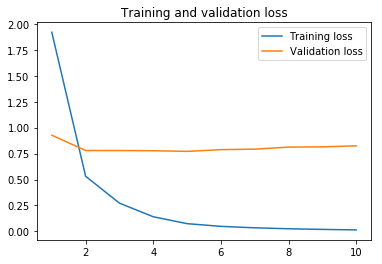

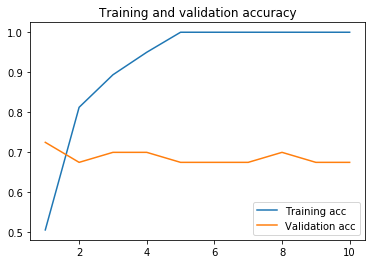

In [24]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#### 1D convnt

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1))

model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           67232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,074,465
Trainable params: 74,465
Non-trainable params: 3,000,000
_____________________________________________________________

In [26]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2)
#                     validation_data=(x_val, y_val))

# model.save_weights('pre_trained_word2vec_model.h5')

Train on 160 samples, validate on 40 samples
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
160/160 [==============================] - 3s 21ms/sample - loss: 0.7269 - acc: 0.4750 - val_loss: 0.7197 - val_acc: 0.4500
Epoch 2/10
160/160 [==============================] - 0s 247us/sample - loss: 0.6197 - acc: 0.7000 - val_loss: 0.7166 - val_acc: 0.4500
Epoch 3/10
160/160 [==============================] - 0s 229us/sample - loss: 0.5622 - acc: 0.8375 - val_loss: 0.7157 - val_acc: 0.4750
Epoch 4/10
160/160 [==============================] - 0s 235us/sample - loss: 0.5142 - acc: 0.8875 - val_loss: 0.7130 - val_acc: 0.4750
Epoch 5/10
160/160 [==============================] - 0s 229us/sample - loss: 0.4787 - acc: 0.9312 - val_loss: 0.7129 - val_acc: 0.4750
Epoch 6/10
160/160 [==============================] - 0s 227us/sample - loss: 0.4465 - acc: 0.9625 - val_loss: 0.7067 - val_acc: 0.5000
Epoch 7/10
160/160 [==============================] - 0s 213us

In [27]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 2s 70us/sample - loss: 0.7254 - acc: 0.5050
Metric  loss : 0.72535
Metric  acc : 0.50504


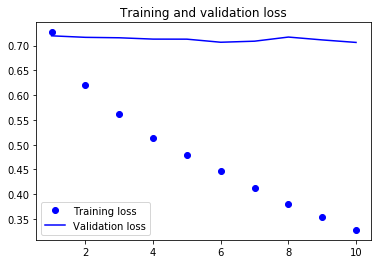

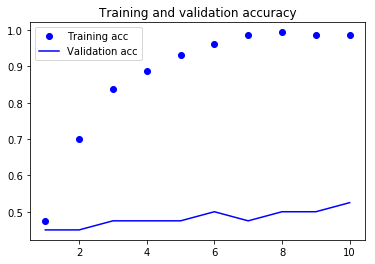

In [28]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### FASTTEXT

https://fasttext.cc/docs/en/english-vectors.html

In [11]:
# crawl-300d-2M.vec.zip: 2 million word vectors trained on Common Crawl (600B tokens).

link = "https://drive.google.com/file/d/1jkJmSpRVZr_V2vGGkLmoEio6eY2Q2el-/view?usp=sharing"

_, id_t = link.split('d/')


id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1jkJmSpRVZr_V2vGGkLmoEio6eY2Q2el-


In [12]:
!ls

aclImdb      crawl-300d-2M.vec.zip  GoogleNews-vectors-negative300.bin
aclImdb.zip  glove.840B.300d.txt    __MACOSX
adc.json     glove.840B.300d.zip    sample_data


In [13]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
!rm crawl-300d-2M.vec.zip

In [14]:
!ls

aclImdb		   crawl-300d-2M.vec.zip	       __MACOSX
aclImdb.zip	   glove.840B.300d.txt		       sample_data
adc.json	   glove.840B.300d.zip
crawl-300d-2M.vec  GoogleNews-vectors-negative300.bin


In [0]:
gensim_fasttext = KeyedVectors.load_word2vec_format('./crawl-300d-2M.vec')

In [16]:
gensim_fasttext['and']

array([-1.081e-01,  1.910e-02,  3.540e-02,  1.270e-02,  6.640e-02,
       -1.260e-02, -1.882e-01,  6.310e-02, -2.306e-01,  9.500e-03,
        9.170e-02,  1.513e-01,  5.580e-02, -6.430e-02, -2.880e-02,
       -4.470e-02,  1.603e-01,  6.130e-02,  3.490e-02, -5.780e-02,
        3.000e-04, -1.399e-01,  1.630e-02, -4.190e-02, -4.870e-02,
        5.700e-03,  1.700e-03, -2.680e-02, -1.700e-02,  1.045e-01,
        8.150e-02, -6.000e-03,  6.350e-02, -1.710e-01,  2.760e-02,
       -2.300e-02,  8.240e-02,  3.040e-02, -1.595e-01,  8.510e-02,
       -5.560e-02,  3.290e-02, -9.210e-02,  1.960e-02, -4.040e-02,
        3.610e-02, -8.430e-02,  1.014e-01, -3.930e-02, -1.805e-01,
       -7.300e-03,  2.247e-01, -6.210e-02, -5.750e-02, -3.160e-02,
        1.980e-02,  6.020e-02,  1.312e-01, -1.278e-01,  1.770e-02,
       -6.000e-02, -2.904e-01, -4.650e-02, -1.078e-01, -7.010e-02,
       -4.970e-02, -1.102e-01,  1.560e-02, -5.950e-02,  7.620e-02,
        2.638e-01,  3.530e-02,  7.450e-02,  3.610e-02, -5.610e

In [19]:
gensim_fasttext['hsyo']

KeyError: ignored

This kind of error occuer when we try to get a word that is not in the disctionarry 

In [0]:
gensim_fasttext['hello'].shape

(300,)

In [0]:
type(gensim_fasttext['0'])

numpy.ndarray

In [17]:
# 2000000 words
len(gensim_fasttext.vocab)

1999995

In [0]:
embedding_dim = gensim_fasttext['hello'].shape[0]

# Cuts off reviews after 100 words
maxlen = 500

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        if word not in gensim_fasttext.vocab:
            pass;
        else :
            embedding_vector = gensim_fasttext[word]
        # cheking that th eword exist in the embedding dictionary
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix[-1]

array([ 0.145     , -0.38229999,  0.22849999, -0.43020001,  0.002     ,
       -0.1035    ,  0.0786    , -0.0783    ,  0.25830001, -0.1183    ,
       -0.0126    ,  0.57870001, -0.0334    ,  0.1903    , -0.0063    ,
        0.21160001,  0.0955    , -0.58200002,  0.1857    , -0.56379998,
       -0.1648    , -0.24869999,  0.2045    , -0.2617    , -0.90850002,
       -0.50419998,  0.2016    , -0.1       , -0.13150001, -0.2221    ,
       -0.0561    ,  0.0122    , -0.122     ,  0.0241    ,  0.039     ,
        0.0712    ,  0.0503    , -0.1353    ,  0.59960002,  0.072     ,
       -0.35260001, -0.0226    , -0.3143    , -0.0589    , -0.0439    ,
       -0.3872    ,  0.3457    , -0.39219999,  0.3204    ,  0.0828    ,
       -0.26679999,  0.1955    ,  0.87970001,  0.4411    ,  0.3364    ,
       -0.0469    ,  0.21780001, -0.13689999, -0.0319    ,  0.1604    ,
       -0.064     , -0.0272    , -0.0692    ,  0.2339    , -0.3716    ,
        0.0802    ,  0.0832    ,  0.0105    ,  0.0396    , -0.51

In [19]:
print(f"Max_words = {max_words}, \nEmbedding_dim = {embedding_dim} and \nInput_length = {maxlen}")

Max_words = 10000, 
Embedding_dim = 300 and 
Input_length = 500


In [20]:
model = tf.keras.Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3000000   
_________________________________________________________________
flatten (Flatten)            (None, 150000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4800032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,800,065
Trainable params: 4,800,065
Non-trainable params: 3,000,000
_________________________________________________________________


In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2)
#                     validation_data=(x_val, y_val))

# model.save_weights('pre_trained_word2vec_model.h5')

Train on 160 samples, validate on 40 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
160/160 [==============================] - 1s 7ms/sample - loss: 0.7099 - acc: 0.5188 - val_loss: 0.6951 - val_acc: 0.5250
Epoch 2/10
160/160 [==============================] - 0s 232us/sample - loss: 0.3298 - acc: 0.9875 - val_loss: 0.6964 - val_acc: 0.5250
Epoch 3/10
160/160 [==============================] - 0s 220us/sample - loss: 0.1778 - acc: 1.0000 - val_loss: 0.6830 - val_acc: 0.5250
Epoch 4/10
160/160 [==============================] - 0s 219us/sample - loss: 0.1025 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.5000
Epoch 5/10
160/160 [==============================] - 0s 227us/sample - loss: 0.0654 - acc: 1.0000 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 6/10
160/160 [==============================] - 0s 219us/sample - loss: 0.0450 - acc: 1.0000 - val_loss: 0.6700 - val_acc: 0.5000
Epoch 7/10
160/160 [==============================] - 0s 221us/sample - loss: 0.0325 - acc: 1

In [22]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 1s 57us/sample - loss: 0.7300 - acc: 0.5169
Metric  loss : 0.72998
Metric  acc : 0.51688


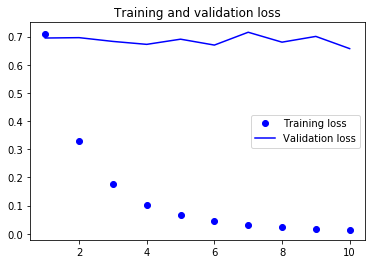

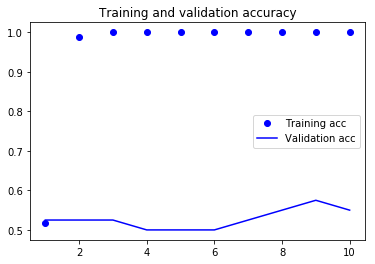

In [23]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#### 1D convnt

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1))

model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           67232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,074,465
Trainable params: 74,465
Non-trainable params: 3,000,000
_____________________________________________________________

In [25]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2)
#                     validation_data=(x_val, y_val))

# model.save_weights('pre_trained_word2vec_model.h5')

Train on 160 samples, validate on 40 samples
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
160/160 [==============================] - 3s 19ms/sample - loss: 0.7494 - acc: 0.5875 - val_loss: 0.8298 - val_acc: 0.5000
Epoch 2/10
160/160 [==============================] - 0s 242us/sample - loss: 0.6307 - acc: 0.6875 - val_loss: 0.8051 - val_acc: 0.4500
Epoch 3/10
160/160 [==============================] - 0s 217us/sample - loss: 0.5840 - acc: 0.7188 - val_loss: 0.8371 - val_acc: 0.5000
Epoch 4/10
160/160 [==============================] - 0s 205us/sample - loss: 0.5464 - acc: 0.8062 - val_loss: 0.8307 - val_acc: 0.5000
Epoch 5/10
160/160 [==============================] - 0s 212us/sample - loss: 0.5133 - acc: 0.8438 - val_loss: 0.8199 - val_acc: 0.5250
Epoch 6/10
160/160 [==============================] - 0s 217us/sample - loss: 0.4761 - acc: 0.8687 - val_loss: 0.8411 - val_acc: 0.4750
Epoch 7/10
160/160 [==============================] - 0s 273us

In [26]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 2s 70us/sample - loss: 0.8033 - acc: 0.4990
Metric  loss : 0.80333
Metric  acc : 0.49904


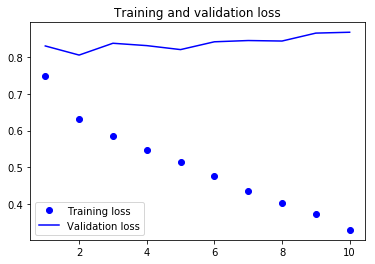

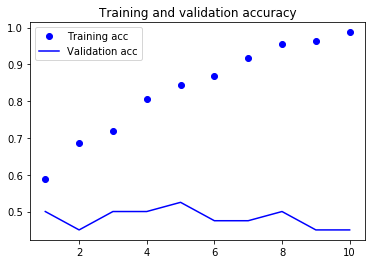

In [27]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### Inter-word relationships and sentence structure (Embedding Learned from tak)

#### 1D convolutional layers

We will now add, 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole

#### Preprocess

In [32]:
# Number of words to 
# consider as features
max_features = 10000      # Words are ranked

# Cuts off texts after this many words (among 
# the max_features most common words)
max_len = 500

print('Loading data...')
(x_train_, y_train_), (x_test_, y_test_) = tf.keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train_), 'train sequences')
print(len(x_test_), 'test sequences')

print('Pad sequences (samples x time)')
x_train_ = tf.keras.preprocessing.sequence.pad_sequences(
    x_train_, maxlen=max_len)
x_test_ = tf.keras.preprocessing.sequence.pad_sequences(
    x_test_, maxlen=max_len)
print('x_train shape:', x_train_.shape)
print('x_test shape:', x_test_.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [33]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, 
                                 activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 494, 32)           67232     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,074,465
Trainable params: 3,074,465
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), # lr=1e-4
              loss=tf.keras.losses.binary_crossentropy,
             metrics=['acc'])

model.fit(x_train_, y_train_,
          epochs=10, batch_size=128,
          validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 147us/sample - loss: 1.2342 - acc: 0.5059 - val_loss: 0.6898 - val_acc: 0.5548
Epoch 2/10
20000/20000 [==============================] - 3s 129us/sample - loss: 0.6720 - acc: 0.6323 - val_loss: 0.6604 - val_acc: 0.6816
Epoch 3/10
20000/20000 [==============================] - 3s 127us/sample - loss: 0.6083 - acc: 0.7843 - val_loss: 0.5779 - val_acc: 0.7664
Epoch 4/10
20000/20000 [==============================] - 3s 128us/sample - loss: 0.4746 - acc: 0.8332 - val_loss: 0.4356 - val_acc: 0.8350
Epoch 5/10
20000/20000 [==============================] - 3s 127us/sample - loss: 0.3574 - acc: 0.8722 - val_loss: 0.3804 - val_acc: 0.8546
Epoch 6/10
20000/20000 [==============================] - 3s 127us/sample - loss: 0.2992 - acc: 0.8943 - val_loss: 0.3690 - val_acc: 0.8636
Epoch 7/10
20000/20000 [==============================] - 3s 128us/sample - loss: 0.2586 - acc: 0.9119 - val_lo

In [35]:
result = model.evaluate(x_test_, y_test_)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],5)))

25000/25000 [==============================] - 2s 66us/sample - loss: 0.5277 - acc: 0.8643
Metric  loss : 0.52774
Metric  acc : 0.86432


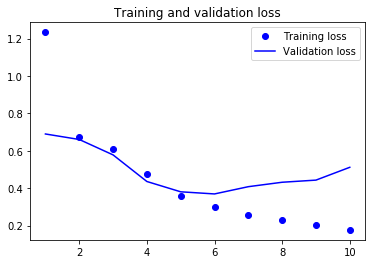

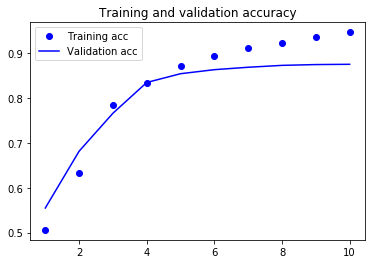

In [36]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [0]:
# model.load_weights('pre_trained_glove_model.h5')
# result = model.evaluate(x_test, y_test)
# for i in range(len(model.metrics_names)):
#      print("Metric ",model.metrics_names[i],":", str(round(result[i],2)))

**We can see that learned task embedding give better result than using pre-trained word embedding.**

**Regarding the 1D convnet, we noticed that using it together with pre-trained word embedding improove our accuracy.**

<h2>About the Authors:</h2> 

<a href="https://salomonkabongo.wixsite.com/datascientist">Salomon Kabongo KABENAMUALU</a>, Master degree student at <a href="https://aims.ac.za/">the African Institute for mathematical SCiences (AIMS South Africa)</a> his research focused on the use machine learning technique in the field of Natural Language Processing.

References : <a href="https://www.manning.com/books/deep-learning-with-python"> Francois Chollet - Deep Learning with Python-Manning Publications (*Book*) </a>

Copyright &copy; 2019. This notebook and its source code are released under the terms of the <a href="https://www.apache.org/licenses/LICENSE-2.0">Apache License 2.0</a>.